Using device: cuda
Checking dataset structure...
Number of classes detected: 23
Class weights computed for 23 classes.

Creating non-shuffled loaders for feature extraction...

Training efficientnet with Mixup...


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 129MB/s] 


Epoch 1/10 | Train Loss: 0.8517 Acc: 0.6490 | Val Loss: 0.1216 Acc: 0.9674
Epoch 2/10 | Train Loss: 0.4771 Acc: 0.7241 | Val Loss: 0.0838 Acc: 0.9770
Epoch 3/10 | Train Loss: 0.4426 Acc: 0.7388 | Val Loss: 0.0740 Acc: 0.9807
Epoch 4/10 | Train Loss: 0.4090 Acc: 0.7413 | Val Loss: 0.0556 Acc: 0.9885
Epoch 5/10 | Train Loss: 0.3895 Acc: 0.7386 | Val Loss: 0.0619 Acc: 0.9853
Epoch 6/10 | Train Loss: 0.3817 Acc: 0.7473 | Val Loss: 0.0482 Acc: 0.9909
Epoch 7/10 | Train Loss: 0.3123 Acc: 0.7585 | Val Loss: 0.0433 Acc: 0.9913
Epoch 8/10 | Train Loss: 0.3069 Acc: 0.7661 | Val Loss: 0.0373 Acc: 0.9933
Epoch 9/10 | Train Loss: 0.3294 Acc: 0.7703 | Val Loss: 0.0449 Acc: 0.9926
Epoch 10/10 | Train Loss: 0.3036 Acc: 0.7578 | Val Loss: 0.0411 Acc: 0.9917

Training densenet with Mixup...


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 144MB/s]


Epoch 1/10 | Train Loss: 0.8968 Acc: 0.6641 | Val Loss: 0.1461 Acc: 0.9605
Epoch 2/10 | Train Loss: 0.4388 Acc: 0.7563 | Val Loss: 0.0852 Acc: 0.9763
Epoch 3/10 | Train Loss: 0.4302 Acc: 0.7491 | Val Loss: 0.0708 Acc: 0.9843
Epoch 4/10 | Train Loss: 0.3823 Acc: 0.7400 | Val Loss: 0.0431 Acc: 0.9892
Epoch 5/10 | Train Loss: 0.3779 Acc: 0.7365 | Val Loss: 0.0493 Acc: 0.9887
Epoch 6/10 | Train Loss: 0.3514 Acc: 0.7350 | Val Loss: 0.0492 Acc: 0.9895
Epoch 7/10 | Train Loss: 0.3064 Acc: 0.7647 | Val Loss: 0.0416 Acc: 0.9912
Epoch 8/10 | Train Loss: 0.2841 Acc: 0.7436 | Val Loss: 0.0374 Acc: 0.9919
Epoch 9/10 | Train Loss: 0.2974 Acc: 0.7538 | Val Loss: 0.0377 Acc: 0.9913
Epoch 10/10 | Train Loss: 0.2752 Acc: 0.7529 | Val Loss: 0.0322 Acc: 0.9915

Extracting features for ensemble...
Ensemble feature shape: (28580, 2350)

Training ensemble models...
Training random_forest...
random_forest Validation Accuracy: 0.9944
Training logistic_regression...
logistic_regression Validation Accuracy: 0.99

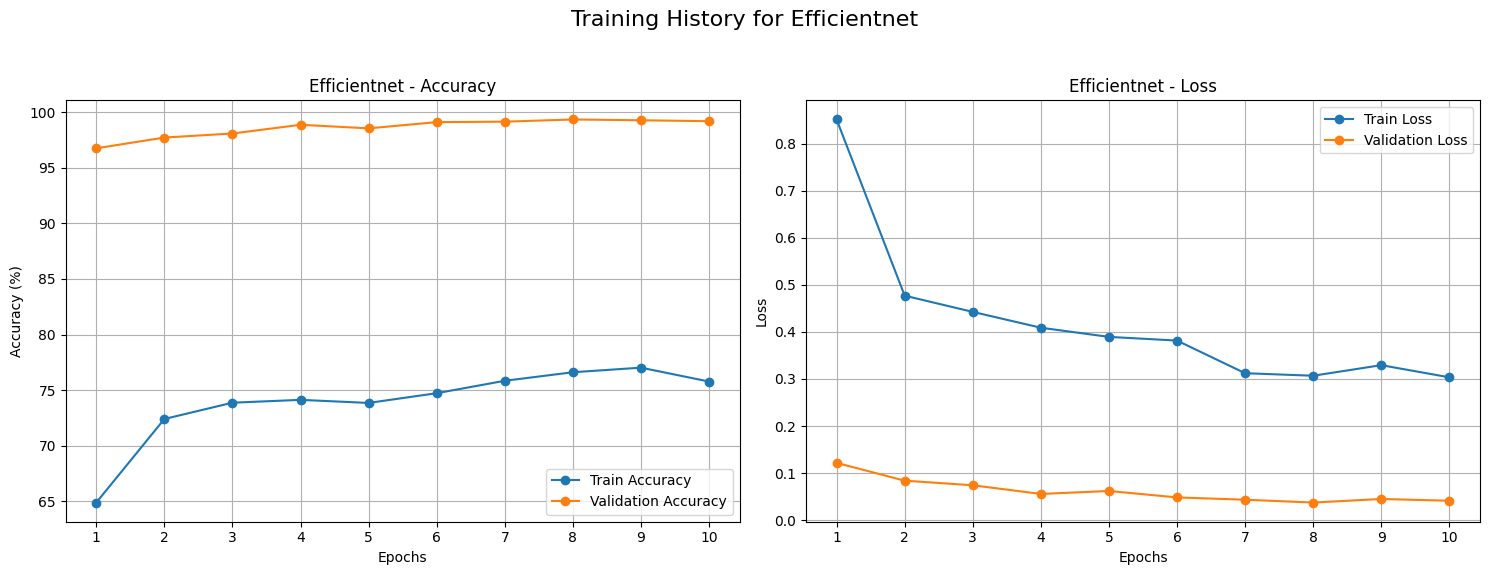

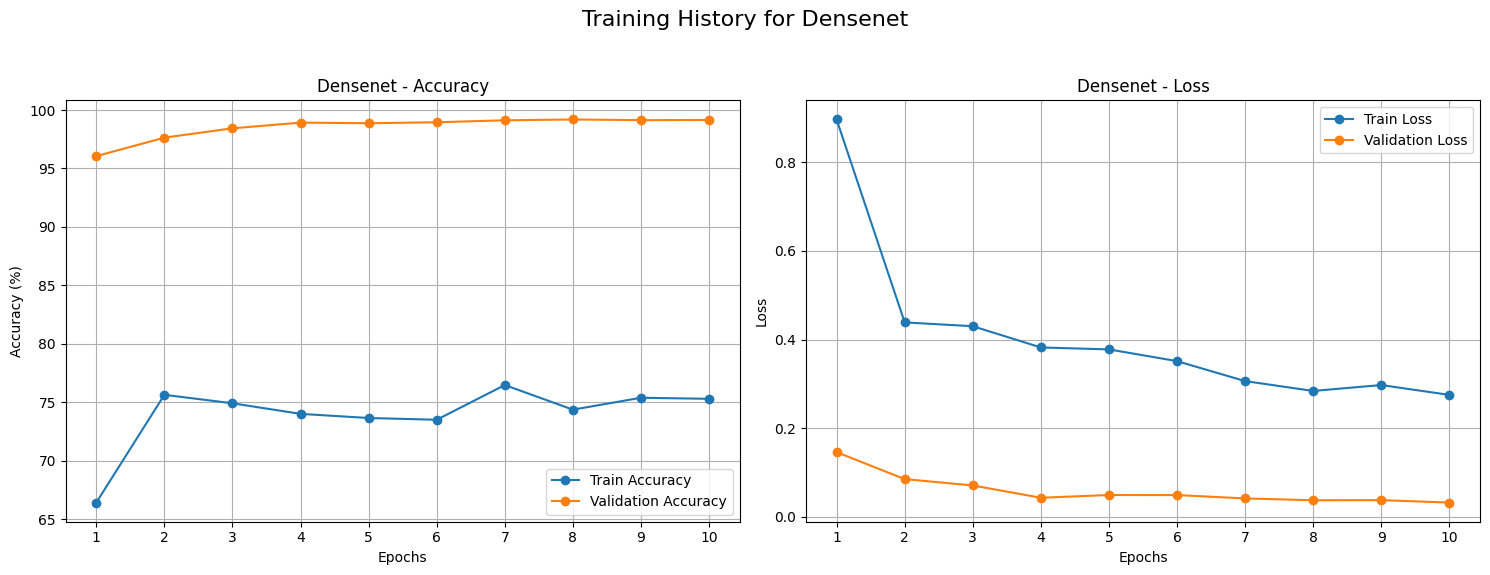

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Configuration
BASE_DIR = r"/kaggle/input/plant-disease-detection/Dataset"
DATA_DIR = os.path.join(BASE_DIR)
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10  # Increased to 10

# Data augmentation - separate for train and validation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Check dataset
print("Checking dataset structure...")
if not os.path.exists(DATA_DIR):
    raise FileNotFoundError(f"Dataset directory not found at: {DATA_DIR}")

temp_dataset = ImageFolder(DATA_DIR, transform=transforms.ToTensor())
NUM_CLASSES = len(temp_dataset.classes)
labels = temp_dataset.classes
print(f"Number of classes detected: {NUM_CLASSES}")

# Train/Val split
train_size = int(0.8 * len(temp_dataset))
val_size = len(temp_dataset) - train_size
train_indices, val_indices = torch.utils.data.random_split(
    range(len(temp_dataset)), [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)

train_dataset = ImageFolder(DATA_DIR, transform=train_transforms)
val_dataset = ImageFolder(DATA_DIR, transform=val_transforms)
train_subset = Subset(train_dataset, train_indices.indices)
val_subset = Subset(val_dataset, val_indices.indices)

y_train_for_weights = [temp_dataset.targets[i] for i in train_indices.indices]
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_for_weights), y=y_train_for_weights)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print(f"Class weights computed for {len(class_weights)} classes.")

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("\nCreating non-shuffled loaders for feature extraction...")
train_dataset_for_extraction = ImageFolder(DATA_DIR, transform=val_transforms)
train_subset_for_extraction = Subset(train_dataset_for_extraction, train_indices.indices)
train_loader_no_shuffle = DataLoader(train_subset_for_extraction, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
val_loader_no_shuffle = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

def create_enhanced_cnn_model(model_name, num_classes=NUM_CLASSES):
    if model_name == "efficientnet":
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
    elif model_name == "densenet":
        model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
    
    # Freeze early layers
    for i, param in enumerate(model.parameters()):
        if i < len(list(model.parameters())) * 0.7:
            param.requires_grad = False
            
    # Replace the classifier
    if model_name == "efficientnet":
        num_ftrs = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )
    elif model_name == "densenet":
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )
    return model

def mixup_data(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1
    index = torch.randperm(x.size(0), device=x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    return mixed_x, y, y[index], lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train_model(model, train_loader, val_loader, model_name, num_epochs=EPOCHS):
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    best_acc = 0.0
    best_model_state = None
    history = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}
    
    for epoch in range(num_epochs):
        model.train()
        running_loss, running_corrects, total_samples = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            if np.random.random() < 0.5:
                inputs, labels_a, labels_b, lam = mixup_data(inputs, labels, alpha=0.2)
                outputs = model(inputs)
                loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)
        
        train_loss, train_acc = running_loss / total_samples, running_corrects.double() / total_samples
        
        model.eval()
        val_loss, val_corrects, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels)
                val_total += inputs.size(0)
        
        val_loss, val_acc = val_loss / val_total, val_corrects.double() / val_total
        scheduler.step()
        history.update({
            "train_acc": history["train_acc"] + [train_acc.item()],
            "val_acc": history["val_acc"] + [val_acc.item()],
            "train_loss": history["train_loss"] + [train_loss],
            "val_loss": history["val_loss"] + [val_loss]
        })
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_state = model.state_dict().copy()
    
    model.load_state_dict(best_model_state)
    return model, history

cnn_models = {}
histories = {}
for model_name in ["efficientnet", "densenet"]:
    print(f"\n{'='*50}\nTraining {model_name} with Mixup...\n{'='*50}")
    model = create_enhanced_cnn_model(model_name).to(device)
    cnn_models[model_name], histories[model_name] = train_model(model, train_loader, val_loader, model_name)

def extract_features_fixed(models_dict, loader):
    features_per_model = {name: [] for name in models_dict}
    predictions_per_model = {name: [] for name in models_dict}
    all_labels = []
    for inputs, labels in loader:
        inputs, all_labels = inputs.to(device), all_labels + labels.cpu().numpy().tolist()
        with torch.no_grad():
            for model_name, model in models_dict.items():
                model.eval()
                if model_name == "efficientnet":
                    x = model.avgpool(model.features(inputs))
                else:
                    x = nn.functional.adaptive_avg_pool2d(
                        nn.functional.relu(model.features(inputs), inplace=True), (1, 1))
                features = torch.flatten(x, 1)
                predictions = torch.softmax(model(inputs), dim=1)
                features_per_model[model_name].append(features.cpu().numpy())
                predictions_per_model[model_name].append(predictions.cpu().numpy())
    final_features = [np.vstack(features_per_model[name]) for name in models_dict]
    final_predictions = [np.vstack(predictions_per_model[name]) for name in models_dict]
    return np.hstack(final_features), np.hstack(final_predictions), np.array(all_labels)

print("\nExtracting features for ensemble...")
train_features, train_predictions, y_train_ensemble = extract_features_fixed(cnn_models, train_loader_no_shuffle)
val_features, val_predictions, y_val_ensemble = extract_features_fixed(cnn_models, val_loader_no_shuffle)

scaler = StandardScaler().fit(train_features)
train_features_scaled, val_features_scaled = scaler.transform(train_features), scaler.transform(val_features)
X_train_ensemble = np.hstack([train_features_scaled, train_predictions])
X_val_ensemble = np.hstack([val_features_scaled, val_predictions])
print(f"Ensemble feature shape: {X_train_ensemble.shape}")

ensemble_models = {
    "random_forest": RandomForestClassifier(n_estimators=100, max_depth=10, class_weight="balanced", random_state=SEED, n_jobs=-1),
    "logistic_regression": LogisticRegression(multi_class="multinomial", max_iter=1000, C=1.0, random_state=SEED, n_jobs=-1),
    "xgboost": XGBClassifier(objective="multi:softmax", num_class=NUM_CLASSES, use_label_encoder=False, eval_metric='mlogloss', random_state=SEED, n_jobs=-1),
    "lightgbm": LGBMClassifier(objective="multiclass", num_class=NUM_CLASSES, random_state=SEED, n_jobs=-1, verbosity=-1)
}

print("\nTraining ensemble models...")
ensemble_scores = {}
for name, model in ensemble_models.items():
    print(f"Training {name}...")
    model.fit(X_train_ensemble, y_train_ensemble)
    ensemble_scores[name] = accuracy_score(y_val_ensemble, model.predict(X_val_ensemble))
    print(f"{name} Validation Accuracy: {ensemble_scores[name]:.4f}")

# --- NEW: Stacking Layer ---
print(f"\n{'='*50}\nCreating Stacking Layer...\n{'='*50}")

# 1. Identify the best individual CNN model
individual_accuracies = {name: h['val_acc'][-1] for name, h in histories.items()}
best_cnn_name = max(individual_accuracies, key=individual_accuracies.get)
print(f"Identified Best CNN: {best_cnn_name} (Accuracy: {individual_accuracies[best_cnn_name]:.4f})")

# 2. Identify the best ensemble model
best_ensemble_name = max(ensemble_scores, key=ensemble_scores.get)
best_ensemble_model = ensemble_models[best_ensemble_name]
print(f"Identified Best Ensemble Model: {best_ensemble_name} (Accuracy: {ensemble_scores[best_ensemble_name]:.4f})")

# 3. Get predictions (probabilities) from the best models to use as features
cnn_model_order = list(cnn_models.keys())
best_cnn_index = cnn_model_order.index(best_cnn_name)
start_col = best_cnn_index * NUM_CLASSES
end_col = start_col + NUM_CLASSES
best_cnn_train_probs = train_predictions[:, start_col:end_col]
best_cnn_val_probs = val_predictions[:, start_col:end_col]

best_ensemble_train_probs = best_ensemble_model.predict_proba(X_train_ensemble)
best_ensemble_val_probs = best_ensemble_model.predict_proba(X_val_ensemble)

# 4. Create the new training and validation sets for the meta-learner
X_train_stacked = np.hstack([best_cnn_train_probs, best_ensemble_train_probs])
X_val_stacked = np.hstack([best_cnn_val_probs, best_ensemble_val_probs])
print(f"Stacked feature shape: {X_train_stacked.shape}")

# 5. Train the final meta-learner
print("\nTraining final meta-learner (Logistic Regression)...")
meta_learner = LogisticRegression(max_iter=1000, random_state=SEED, n_jobs=-1)
meta_learner.fit(X_train_stacked, y_train_ensemble)

# 6. Evaluate the stacked model
stacked_preds = meta_learner.predict(X_val_stacked)
stacked_accuracy = accuracy_score(y_val_ensemble, stacked_preds)
print(f"✅ Final Stacked Model Validation Accuracy: {stacked_accuracy:.4f}")

# --- Updated Final Summary ---
print(f"\n{'='*50}\nModel Comparison Summary\n{'='*50}")
print("--- Tier 1: Individual CNNs ---")
for name, acc in individual_accuracies.items():
    print(f"  {name}: {acc:.4f}")

print("\n--- Tier 2: Ensemble Models ---")
for name, acc in ensemble_scores.items():
    marker = " 🏆 (Best Tier 2)" if name == best_ensemble_name else ""
    print(f"  {name}: {acc:.4f}{marker}")

print("\n--- Tier 3: Stacked Meta-Learner ---")
print(f"  Stacked Model (Logistic Regression): {stacked_accuracy:.4f} 🏆 (Best Overall)")

best_overall_accuracy = max(max(individual_accuracies.values()), max(ensemble_scores.values()), stacked_accuracy)
print(f"\nBest Overall Model Accuracy: {best_overall_accuracy:.4f}")

# --- Plotting Training History ---
print(f"\n{'='*50}\nGenerating Training Plots\n{'='*50}")

for model_name, history in histories.items():
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, EPOCHS + 1), [acc * 100 for acc in history['train_acc']], 'o-', label='Train Accuracy')
    plt.plot(range(1, EPOCHS + 1), [acc * 100 for acc in history['val_acc']], 'o-', label='Validation Accuracy')
    plt.title(f'{model_name.capitalize()} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.xticks(range(1, EPOCHS + 1))
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, EPOCHS + 1), history['train_loss'], 'o-', label='Train Loss')
    plt.plot(range(1, EPOCHS + 1), history['val_loss'], 'o-', label='Validation Loss')
    plt.title(f'{model_name.capitalize()} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(range(1, EPOCHS + 1))
    plt.grid(True)
    plt.legend()

    plt.suptitle(f'Training History for {model_name.capitalize()}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    plt.savefig(f'{model_name}_training_plots.png')
    print(f"Saved plot to {model_name}_training_plots.png")




Generating Confusion Matrix
Saved confusion matrix to confusion_matrix.png


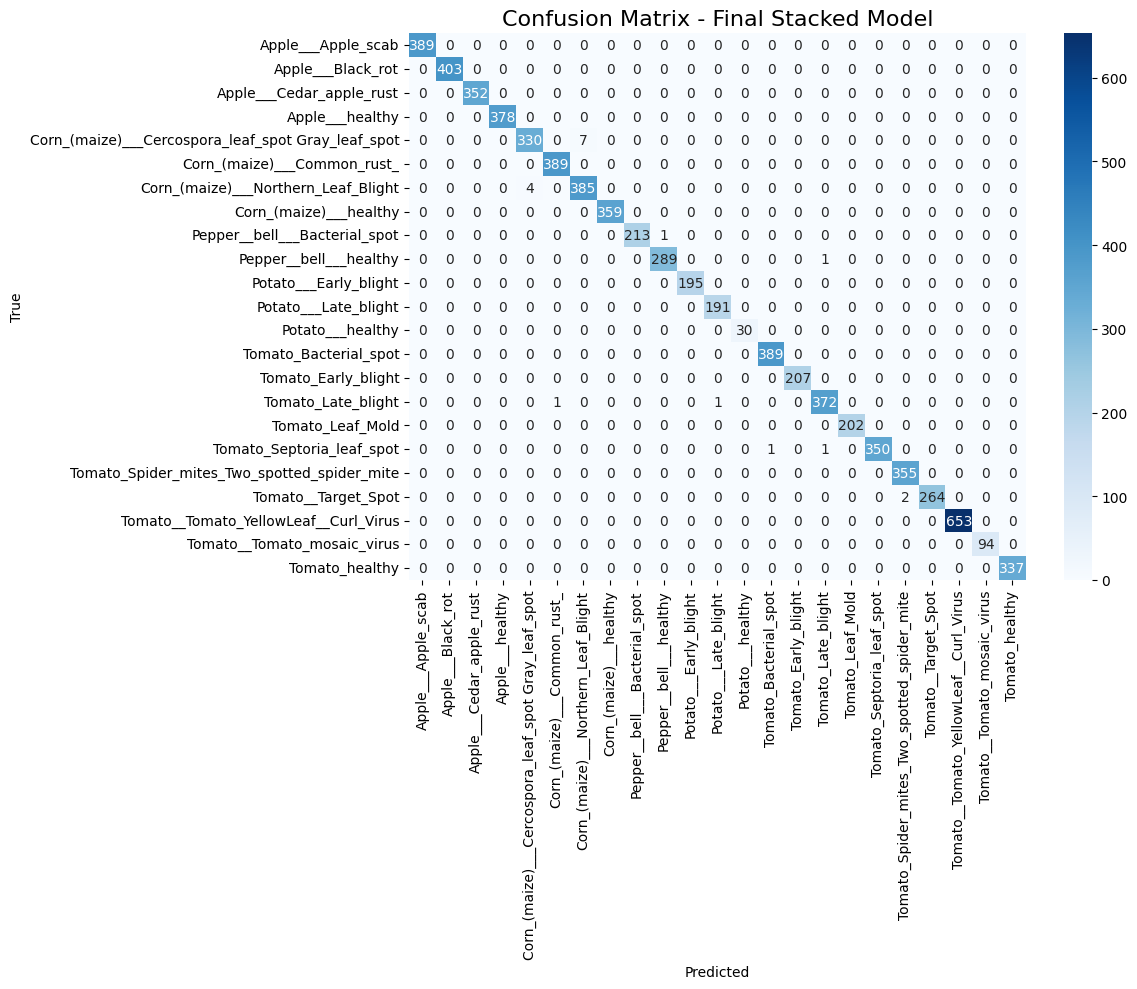

In [2]:
# --- Confusion Matrix ---
print(f"\n{'='*50}\nGenerating Confusion Matrix\n{'='*50}")

cm = confusion_matrix(y_val_ensemble, stacked_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Final Stacked Model", fontsize=16)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("confusion_matrix.png")
print("Saved confusion matrix to confusion_matrix.png")
